# TMA4215 - Assignment 3 - Linear Multistep Methods

**Deadline:** Wednesday September 30, 11:59PM

**For approval:** Upload a Jupyter Notebook in Blackboard with code/answers. Answer Control questions in Blackboard.

**Problem 1.** Predictor corrector method. Implementation.
You shall write a function that implements a Predictor-Corrector scheme as described below. You shall demonstrate that it works on a specified test problem.

We consider a pair of two-step methods, the predictor [P] is the two-step (explicit) Adams-Bashforth method, the corrector is the two-step (implicit) Adams-Moulton method. They read as follows

\begin{align*}
[\text{Adams-Bashforth}]\quad & u_{n+2} - u_{n+1} = h\,\left(\frac32 f_{n+1} - \frac12 f_n\right) \\
[\text{Adams-Moulton}]\quad & u_{n+2} - u_{n+1} = h\, \left(\frac{5}{12}f_{n+2}+\frac23 f_{n+1}-\frac{1}{12} f_n\right)
\end{align*}

With reference to the lectures and section 11.7 in the book (see in particular Example 11.8 on page 514) you shall implement the method as in *PECE* mode with constant step size. You need a starting method for the first step. You may also need a completion method for the last step. For this you will use the second order explicit two-stage Runge-Kutta method known as improved Euler (other names are Heun's method or explicit trapeziodal method). 

$$
\begin{array}{c|rr}
0 & 0 \\
1 & 1 \\ \hline
  & \frac12 & \frac12
\end{array}
$$

So the computation sequence is
1. Take one step with the improved Euler method and step size $h$
2. Do time stepping with the Predictor-Corrector method up to the largest integer $n$ such that $t_n=t_0+nh<T$.
3. If $t_n<T$, Take one final step with the improved Euler method, using the stepsize $h_f = T-t_n$.


**(a)** Write a Python function *ABM2* as indicated in the template below. Its input parameters are
* f  : A function f(t,y) that defines the differental equation
* y0 : The intial value (vector)
* t0 : The initial time
* T  : The final time
* h  : The (constant) stepsize

The output should be 
* TT : A numpy array containing all the Nsteps+1 time values t0,...,T
* YY : A numpy array of dimension (m,Nsteps+1) where m is the dimension of the ODE

(For Problem 1c You may also want to allow for a version that returns only the final value, the solution at time T)

**(b)** Test it out on the Lotka-Volterra Volterra problem

\begin{align*}
\dot{u} &= u(v-2) & u(0)&=2\\
\dot{v} &= v(1-u) & v(0)&=1
\end{align*}

First write the function *LV(t,y)*. Generate a phase plot, where you use $h=0.08$. This means to plot *y[1]* vs
*y[0]* that is, *v* vs *u* in the Lotka-Volterra system above. You should get a closed loop (a periodic solution). Make $T$ just big enough to complete one period.

**Control question 1.** Using ABM2(LV,y0,t0,T,h) where $y_0=[2,1]^T$, $t_0=0$, $T=2$, $h=0.03$, what is the resulting approximation to $u(2)$?

**(c)** You will now learn a very standard method for estimating the convergence order of the method. This is actually a great code verification tool when you are writing software for solving ODEs. We explain it in steps.

1. Let $T$ be the final time in which you want to test (the order of) the method on a given problem.
2. Compute a reference solution at $t=T$, i.e. an approximation *yexact* of high accuracy to the solution at $t=T$. This can be done in different ways. One is to make a call to a builtin function with strict tolerances, e.g. *scipy.integrate* seems to contain several solvers. Another option is to write a simple solver with good accuracy, you could do for instance the standard four stage fourth order Runge-Kutta method. To save you some work, we offer a simple implementation of this method below (RK4) that you can use if you prefer. The important thing with the reference solution is that it is accurate enough to estimate the smallest error in your test.
3. Now, take a suitable range of log-spaced stepsizes. For our problem here, a first attempt could be to set
*HH=numpy.logspace(-4,-1,20)* that gives you a numpy-array of 20 stepsizes log-spaced between $10^{-4}$ and $10^{-1}$.
4. Run the method/implementation you want to test for all these stepsizes up to time $t=T$. For each stepsize $h$ in *HH* , compute  $\|y_T(h)-y_{ex}\|$ where $y_T(h)$ is your approximation at $t=T$ for this stepsize, and $y_{ex}$ is the reference solution *yexact*. Store these values in a numpy-array *err.
5. Now make a loglog-plot of *err* vs *HH*. If the error behaves like $C h^p$ this should give a straight line of slope $p$ in the loglog-plot.
6. Estimate the order as numbers. Since our hypothesis is that for a stepsize $h_i$, the corresponding error is of the form $\mathrm{err}_i \approx Ch_i^{p}$, we can estimate $p$ from two stepsizes $h_1$ and $h_2$.
$$
\mathrm{err}_i \approx Ch_i^{p},\ i=1,2\quad\Rightarrow\quad p \approx \frac{\log\frac{\mathrm{err}_1}{\mathrm{err}_2}}{\log\frac{h_1}{h_2}}
$$
You can compute this expression for every consecutive pair of stepsizes $(h_i, h_{i+1})$.

In your Jupyter Notebook, please implement this order test for the Lotka-Volterra problem to estimate the order of the ABM2 method. In the test, use the LV-function from **(b)**, set $y_0=[2,1]^T$, $t_0=0$, $T=10$ and use stepsizes logspaced in the range $10^{-4},\ldots,10^{-1}$.

**Control question 2.** What seems to be the observed order of the ABM2 implementation described above.


In [94]:
## Answer to problem 1a)
import numpy as np
import matplotlib.pyplot as plt

def ABM2(f,y0,t0,T,h):
    """ABM2 method. """
    m = len(y0) # Dimension of the ODE.
    
    # Could also statically define the arrays that store y, f and t
    # in order to not append, and use indexing in the loop when adding new values instead. 
    
    # Take one step with Heun's method.
    y1 = improved_euler_step(f, t0, y0, h)
    TT = np.array([t0, t0 + h]) # Start-time and one step from Heun. 
    YY = np.zeros((m, 2))
    YY[0, :] = y0
    YY[1, :] = y1
    f0 = f(TT[-2], YY[-2, :])
    f1 = f(TT[-1], YY[-1, :])
    FF = np.zeros((m, 2))
    FF[0, :] = f0
    FF[1, :] = f1
    
    while TT[-1]+ h <= T:
        # Corrector until step is ok. 
        u2 = YY[-1, :] + h*((3/2)*FF[-1] - (1/2)*FF[-2]) # Apply Predictor.
        f2 = f(TT[-1], u2) # [E]
        FF = np.vstack((FF, f2)) 
        u2 = YY[-1, :] + h*(5/12*FF[-1, :]+2/3*FF[-2, :]-1/12*FF[-3, :]) # Apply Corrector.
       
        YY = np.vstack((YY, u2)) 
        TT = np.append(TT, TT[-1] + h)
        FF[-1, :] = f(TT[-1], u2) # Need to update f after each calculated u2. 
    
    if TT[-1] + h > T:
        yn = improved_euler_step(f, TT[-1], YY[-1, :], T - TT[-1])
        YY = np.vstack((YY, yn))
        TT = np.append(TT, T)
        
    # Mangler en siste YY ?? Hvorfor kun 67? Møøkkk!
    return TT,YY


def LV(t,y):
    yd = np.array([y[0]*(y[1]-2), y[1]*(1-y[0])])
    return yd

def improved_euler_step(f, t0, y0, h):
    k1 = f(t0, y0)
    k2 = f(t0+h, y0+h*k1)
    return (1/2)*h*(k1+k2) + y0

    
def phase_plot():
    """Generate phase plot for Lotke-Volterra."""
    h = 0.08
    T = 10
    y0 = np.array([2, 1])
    t0 = 0
    TT, YY = ABM2(LV, y0, t0, T, h)
    plt.plot(YY[:, 0], YY[:, 1])
    plt.xlabel("u")
    plt.ylabel("v")
    plt.title("Phase Plot for Lotke-Volterra")
    plt.show()



# To answer control question 1. 
y0 = np.array([2, 1])
t0 = 0
T = 2
h = 0.03
# Test the function with the given values (above)
TT, YY = ABM2(LV, y0, t0, T, h)

**SUPPLIED FUNCTION RK4** (can be used to get reference solution in 1c)

In [95]:
def RK4(f,y0,t0,T,h):
    ''' This version stores only the final value'''
    N=int((T-t0)/h)
    t=t0
    y=y0
    
    for n in range(N):
        K1 = f(t,y)
        K2 = f(t+h/2,y+h/2*K1)
        K3 = f(t+h/2,y+h/2*K2)
        K4 = f(t+h,y+h*K3)
        y  = y + h/6*(K1+2*K2+2*K3+K4)
        t  = t+h
    if t < T:
        hf = T-t
        K1 = f(t,y)
        K2 = f(t+hf/2,y+hf/2*K1)
        K3 = f(t+hf/2,y+hf/2*K2)
        K4 = f(t+hf,y+hf*K3)
        y  = y + hf/6*(K1+2*K2+2*K3+K4)
    return T, y




Answer to 1b)


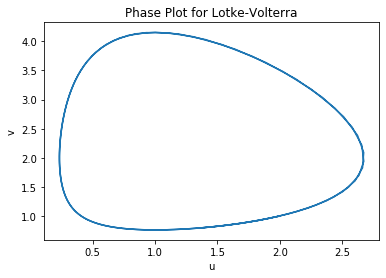

Answer to Control question 1
The resulting approximation to u(2) is 0.2521691867603104


 Answer to 1c)



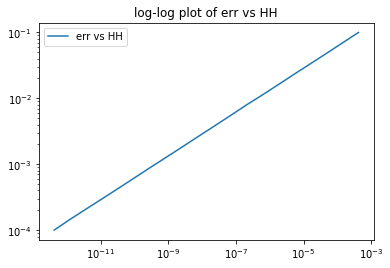

List of estimates of p: [0.         2.8804485  3.0262832  3.04619017 3.0318367  2.98584774
 2.97644566 3.02940689 3.02422439 2.97494409 3.02145909 2.97284295
 2.93696096 3.10130332 3.00344512 2.97377459 3.02119024 3.01418255
 2.97200128 2.98695615]
Mean of p: 2.848987178409061



Answer to Control question 2
The observed order of ABM2 seems to be (approximately) 3


In [121]:
import matplotlib.pyplot as plt

def oneb():
    """Answer to 1b)."""
    print("Answer to 1b)")
    phase_plot() # Generate the phase plot of Lotke-Volterra. 
    y0 = np.array([2, 1])
    t0 = 0
    T = 2
    h = 0.03
    TT, YY = ABM2(LV, y0, t0, T, h)
    # Answer to Control question 1

    print("Answer to Control question 1")
    print("The resulting approximation to u(2) is", YY[-1][0])

# 1c)  order test 

def onec():
    """Answer to 1c)."""
    print("\n\n Answer to 1c)\n")
    HH = np.logspace(-4,-1,20)
    y0 = np.array([2, 1])
    t0 = 0
    T = 2
    err = np.zeros(len(HH))
    #_, yexact = RK4(LV, y0, t0, T, 0.0001) # Does not seem to matter if this is calculated outside or in the loop.
    for i in range(len(HH)):
        _, yexact = RK4(LV, y0, t0, T, HH[i])
        _, yT = ABM2(LV, y0, t0, T, HH[i])
        err[i] = np.linalg.norm(yexact-yT[-1])
        
    
    # Estimate the order as values (numbers) as described. 
    p = np.zeros(len(HH))
    for i in range(1, len(HH)):
        p[i] = np.log(err[i-1]/err[i])/np.log(HH[i-1]/HH[i])
    
    plt.plot(err, HH, label="err vs HH")
    plt.title("log-log plot of err vs HH")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.show()
    
    # Print estimates for p. 
    print("List of estimates of p:", p)
    print("Mean of p:", sum(p)/len(p))
    # Answer to Control question 2

    print("\n\n\nAnswer to Control question 2")
    print("The observed order of ABM2 seems to be (approximately) 3")

oneb()
onec()

**Problem 2.** Determine which (if any) of the following linear multistep methods are convergent. If convergent, determine also the order of the method. Include your argument and some calculations as you see fit.

**(a)**

$$
u_{n+3}+u_{n+2} - u_{n+1} - u_{n} = \frac{h}{3}(f_{n+3}+5f_{n+2}+5f_{n+1}+f_n)
$$

**(b)**

$$
u_{n+3}-u_{n+2} + u_{n+1} - u_{n} =  \frac{h}{6}(11 f_{n+2}-4 f_{n+1}+5f_n)
$$


**Control question 3.** Is the method in **(2a)** convergent?


**Control question 4.** Is the method in **(2b)** convergent?


A multistep method is covergent iff it is zero stable and consistent. Are any of these two methods exactly that?

**(a)** $\rho (z) = z^3 + z^2 - z - 1$ and $\sigma (z) = \frac{1}{3}z^3 + \frac{5}{3}z^2 + \frac{5}{3}z + \frac{1}{3}$. First, the order will be calculated from $\rho (z)$, which also indicates whether or not the method is consistent (which is the case when the order $p \geq 1$). Need to check if 

$$
    \sum_{i = 0}^{k}\alpha_i = 0, 
$$

and 

$$
    \sum_{i = 0}^{k}\alpha_i i^q = q \sum_{i = 0}^k \beta_i i^{q-1} \quad q = 1, \ldots, p, 
$$

in order to calculate the order $p$ of the method in question. 

$$
    \begin{align*}
        q &= 0: \quad \sum_{i = 0}^3 \alpha_i = 1 + 1 - 1 - 1 = 0 \\
        q &= 1: \quad \sum_{i = 0}^3 i \alpha_i - 1 \cdot \sum_{i = 0}^3 \beta_i = (-1+2+3) - (\frac{1}{3} + \frac{5}{3} + \frac{5}{3} + \frac{1}{3}) = 0 \\
        q &= 2: \quad \sum_{i = 0}^3 i^2 \alpha_i - 1 \cdot \sum_{i = 0}^3 i\beta_i = 6 \neq 0.
    \end{align*}
$$

This means that method **(a)** is of order $p = 1$ and is consistent. Now, we need to check if it is zero-stable, which would mean that it is convergent. 

**(b)** $\rho (z) = z^3 - z^2 + z - 1$ and $\sigma (z) = \frac{11}{6}z^2 - \frac{2}{3}z + \frac{5}{6}$. The same conditions need to be checked in this case. This will be done using the criteria listed in task **(b)** below. Finding the roots of $\rho (z)$ gives $(z-1)(z+1)^2 = 0$. Since the root $z = -1$ has multiplicity 2, the conditions cannot be satisfied, which implies that the method cannot be zero-stable. Therefore, it cannot be convergent either.  

$$
    \begin{align*}
        q &= 0: \quad \sum_{i = 0}^3 \alpha_i = 1 - 1 + 1 - 1 = 0 \\
        q &= 1: \quad \sum_{i = 0}^3 i \alpha_i - 1 \cdot \sum_{i = 0}^2 \beta_i = (1-2+3) - (\frac{5}{6} -\frac{2}{3} + \frac{11}{6}) = 0 \\
        q &= 2: \quad \sum_{i = 0}^3 i^2 \alpha_i - 1 \cdot \sum_{i = 0}^3 i\beta_i = 3 \neq 0
    \end{align*}
$$

This means that method **(b)** is of order $p = 1$ and is consistent. This method is also consistent based on the fact that $\rho (1) = 0$ and $\rho'(1) = \sigma (1)$. Now, given that it is consistent, we need to check if it is zero-stable, which would mean that it is convergent. 

The method is zero-stable if $\rho (z)$ satisfies

* The roots $\zeta_i$ satisfy $|\zeta_i| \leq 1$
* For roots $\zeta_i$ such that $|\zeta_i| = 1$, then the multiplicity of the root is 1. 

Calculating the roots of $\rho (z)$ gives $\rho (z) = (z-1)(z^2+1) = 0$. This means that, since all three roots ($z = 1$, $z = i$ and $z = -i$) have multiplicity 1, the conditions stated above are satisfied and the method is zero-stable. Since it is consistent and zero-stable, it is also convergent, with order $p = 1$.